### The ndex2 python package
The ndex2 package provides a convenient wrapper around the NDEx server API. NDEx networks are transfered in the CX (Cytoscape Exchange) format and ndex2 includes the NiceCX Python to simplify the use of CX data. NiceCX does not provide common network manipulation functionality. For that, it is better to cast the data into forms such as networkx or igraph.

The Sphinx documentation for the ndex2 package is at https://ndex2.readthedocs.io/en/latest/.

Additional documentation and examples, including Jupyter Notebooks are available in the ndex2 GitHub repo: https://github.com/ndexbio/ndex2-client.

In [1]:
#NDEx set up
SERVER = 'ndexbio.org'
USERNAME = input('Username: ')
PASSWORD = input('Password: ')

NETWORK_UUID = 'fa7405cf-3d7f-11ea-bfdc-0ac135e8bacf'
STYLE_NETWORK_UUID = '145a6a47-78ee-11e9-848d-0ac135e8bacf'

PPI_DATA_URL = 'https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/ap-ms-demo-data.csv'
ANNOTATION_DATA_URL = 'https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/annotation-data.csv'

Username: sol015
Password: test


### Download the First Example Network From NDEx to the Python Environment

ndex2.create_nice_cx_from_server makes the request to the specified NDEx server URL with the UUID (universally unique identifier) of the network. The server returns the network in CX format which is used to create a NiceCX object.

In [2]:
#1a. ndex2: download network from NDEx
import ndex2

nice_cx_network = ndex2.create_nice_cx_from_server(SERVER, uuid=NETWORK_UUID)

### Download the Same Network to Cytoscape

The py4Cytoscape package facilitates the use of Cytoscape desktop from Python via CyREST. Cytoscape now runs as a local REST server, its API exposing many of the core operations and the operations provided by Apps. In this case, we use py4Cytoscape to import the same network from NDEx into the Cytoscape environment. The method returns a session ID (SUID) for the downloaded network, enabling us to reference it in the next steps.

By default, py4Cytoscape prints each REST transaction with Cytoscape. While this output can be very helpful for debugging, we will turn it off for the rest of the tutorial.

In [3]:
#1b. py4cytoscape: download network from NDEx
import py4cytoscape as py4

network_suid = py4.cy_ndex.import_network_from_ndex(NETWORK_UUID)

[INFO] py4...S:  ǀHTTP POST(http://localhost:1234/cyndex2/v1/networks), json: {'serverUrl': 'http://ndexbio.org/v2', 'uuid': 'fa7405cf-3d7f-11ea-bfdc-0ac135e8bacf'}
[INFO] py4...S:  ǀOK[200]


In [4]:
#py4cytoscape: disable logging
import logging, sys
logging.disable(sys.maxsize)

### Use Another Network as a Visual Style Template

One of the easiest ways to apply a visual style to a network is to copy that style from another network. This lets you work on the style of your network in Cytoscape using the interactive style editor, then save the network to NDEx for future use as a template.

The CX class provides a special method for this common operation, both downloading the template and copying the style to the target network.

Using py4Cytoscape, we can follow the same strategy, starting by importing the template network. The name of the template network becomes the name of its style and the py4.styles.set_visual_style method assigns that style to another network, specified by that network's SUID.

In [5]:
#2a. ndex2: get a style template network and apply the style to the network
nice_cx_network.apply_template(SERVER, STYLE_NETWORK_UUID)

In [6]:
#2b. py4cytoscape: get a style template network
style_network_suid = py4.cy_ndex.import_network_from_ndex(STYLE_NETWORK_UUID)

In [7]:
#py4cytoscape: apply the style to the network
style_network_name = py4.networks.get_network_name(style_network_suid)
py4.styles.set_visual_style(style_network_name + '-Style', network=network_suid)

{'message': 'Visual Style applied.'}

### Apply a Layout to the Network

In the python environment, we will generate a networkx object using the NiceCX to_networkx method and then use the networkx spiral_layout method to assign positions to the nodes.

The result of the layout operation is a Python dictionary of positions keyed by nodes. We can show the network with that layout using the networkx draw method, passing in the positions.

To set the layout of the NiceCX network, we need to transform the networkx positions to a CX cartesianLayout aspect.

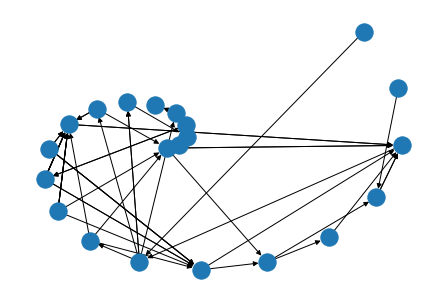

In [8]:
#3a. ndex2: apply a layout to the network
import networkx as nx

#Make and view layout
networkx_network = nice_cx_network.to_networkx(mode='default')
pos = nx.drawing.layout.spiral_layout(networkx_network, scale=1000)
nx.draw(networkx_network, pos)

#Transfer layout back to original network
new_cartesian_layout = []
for node_id, coordinates in pos.items():
    new_cartesian_layout.append({
        'node': node_id,
        'x': coordinates[0],
        'y': coordinates[1]
    })
nice_cx_network.set_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT, new_cartesian_layout)

### Apply a Layout to the Network in Cytoscape
py4Cytoscape can easily access the layouts available in Cytoscape!

In [9]:
#3b. py4cytoscape: apply a layout to the network
py4.layouts.layout_network('force-directed', network=network_suid)

{}

### Save the Network to your NDEx Account with ndex2

NiceCX networks have a convenient one-step upload method. There is also a "update_to" method to update the existing network instead of creating a new one.

In [10]:
#4a. ndex2: save the network to your account in NDEx
nice_cx_network.set_name(nice_cx_network.get_name() + ' (ndex2)')

nice_cx_network.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX


'http://public.ndexbio.org/v2/network/ac3e3b55-ba24-11ea-aaef-0ac135e8bacf'

### Save the Network to your NDEx Account with Cytoscape

py4Cytoscape also has a one-step method. Here you can also control whether the network is publicly accessible or private to your account.

**Note:** By itself, "public" does not mean that users can find the network by searching NDEx. This is so that searches are not cluttered by networks that were convenient to make public but which are not intended for general use. To make a network findable in searches, you need to go to your account on the NDEx site and change that setting.  In the context of a tutorial where you access NDEx programmatically, you can see how important this is: no one wants to find the 20,000 networks you accidentally loaded to your account because of a bug in your code.

In [11]:
#4b. py4cytoscape: save the network to your account in NDEx
py4.set_current_view(network_suid)
new_name = py4.networks.get_network_name(network_suid) + ' (py4)'
py4.networks.rename_network(new_name)

py4.cy_ndex.export_network_to_ndex(USERNAME, PASSWORD, is_public=False, network=network_suid)

'ac929ce7-ba24-11ea-aaef-0ac135e8bacf'

### Load Protein Interaction Data as a Network

Both ndex2 and py4Cytoscape have methods that can transform a pandas dataframe into a network.

Using ndex2, you can specify what each column of the input data contains: source nodes, target nodes, source node attributes, target node attributes, edge interactions, or edge attributes.

Using py4Cytoscape, the dataframe column named "source" automatically becomes the source node column; "target" becomes the target node column, and "interaction" becomes the edge interactions column. All other columns become edge attributes.

**Note:** If this step doesn't work, check that you have [installed python certificates](https://stackoverflow.com/questions/50236117/scraping-ssl-certificate-verify-failed-error-for-http-en-wikipedia-org).

In [12]:
#5. ndex2 and py4cytoscape: load protein interaction tabular data as a pandas dataframe
import pandas as pd
ppi_data = pd.read_csv(PPI_DATA_URL, sep=',')
ppi_data

,Bait,Prey,UniProt,HEKScore,JurkatScore,AP-MS Score
0,GAG,THRAP3,Q9Y2W1,0.807,0.319,0.563
1,GAG,SEPSECS,Q9HD40,0.814,0.200,0.507
2,GAG,IVNS1ABP,Q9Y6Y0,0.753,0.260,0.506
3,GAG,DDX49,Q9Y6V7,0.824,0.000,0.412
4,GAG,PRMT1,Q99873,0.758,0.037,0.397
...,...,...,...,...,...,...
494,GP41,TOMM40,O96008,0.762,0.000,0.381
495,GP41,GLG1,Q92896,0.000,0.762,0.381
496,GP41,NGLY1,Q96IV0,0.000,0.756,0.378
497,GP41,SEC62,Q99442,0.000,0.751,0.376


In [13]:
#5a. ndex2: load protein interaction tabular data as a PPI network
import pandas as pd
ppi_network = ndex2.create_nice_cx_from_pandas(
    ppi_data,
    source_field='Bait',
    target_field='Prey',
    target_node_attr=['UniProt'],
    edge_attr=['HEKScore', 'JurkatScore', 'AP-MS Score']
)
ppi_network.set_name('AP-MS Demo Data (ndex2)')

0


In [20]:
#5b. py4cytoscape: load protein interaction tabular data as a PPI network
import pandas as pd
py4_ppi_data = ppi_data.rename(columns={'Bait': 'source', 'Prey': 'target'})
ppi_network_suid = py4.networks.create_network_from_data_frames(
    edges=py4_ppi_data, 
    title='AP-MS Demo Data (py4)',
    collection='AP-MS Demo Data'
)

Applying default style...
Applying preferred layout


### Annotate the PPI Network with Gene Expression Data

Both ndex2 and py4Cytoscape can be used to add additional data to a network in the form of attributes on nodes, edges, or the network as a whole.

In [21]:
#6. ndex and py4cytoscape: load annotation data as a dataframe
annotation_data = pd.read_csv(ANNOTATION_DATA_URL, sep=',')
annotation_data

,P-value,FCAbsolute,Regulation,GeneSymbol
0,0.027029,2.006743,up,ZNF594
1,0.012443,2.644313,up,GRB10
2,0.007062,1.881797,up,MTHFD2
3,0.044250,3.439971,up,ATF3
4,0.031662,1.955409,up,PMAIP1
...,...,...,...,...
311,0.007729,2.957946,down,SLC2A5
312,0.009410,1.861381,down,NaN
313,0.019493,1.599525,down,NaN
314,0.001827,1.699154,down,INF2


### Annotate the PPI Network with ndex2

Using ndex2, a network can be annotated by matching rows of the input data with the names of nodes in the network. Then, the set_node_attribute method can be used to give the node the attributes found in the matching row of the input data.

In [22]:
#6a. ndex2: annotate the PPI network with tabular gene expression data
for node_id, node in ppi_network.get_nodes():
    data = annotation_data.loc[annotation_data['GeneSymbol'] == node['n']]
    if len(data) == 1:
        for column in data.columns:
            if column == 'GeneSymbol':
                continue
            if column == 'Regulation':
                data_type = 'string'
            else:
                data_type = 'double'
            
            ppi_network.set_node_attribute(node_id, column, data.iloc[0][column], type=data_type)  

### Annotate the PPI Network with py4Cytoscape

py4Cytoscape will do this automatically with the load_table_data method!

In [23]:
#6b. py4cytoscape: annotate the PPI network with tabular gene expression data
py4.tables.load_table_data(annotation_data, data_key_column='GeneSymbol')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/py4cytoscape-0.0.1-py3.8.egg/py4cytoscape/tables.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'Success: Data loaded in defaultnode table'

In [18]:
#7a. ndex2: save PPI network to ndex
ppi_network.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX


'http://public.ndexbio.org/v2/network/ba97c909-ba24-11ea-aaef-0ac135e8bacf'

In [19]:
#7b. py4cytoscape: save PPI network to ndex
py4.cy_ndex.export_network_to_ndex(USERNAME, PASSWORD, is_public=False, network=ppi_network_suid)

'bb01604c-ba24-11ea-aaef-0ac135e8bacf'